Week3 : Histopathologic Cancer Detection<br>

In [39]:
#!pip uninstall -y panda
!pip install tensorflow-io==0.31.0
!pip install tensorflow-io-gcs-filesystem==0.31.0 #scikit-learn 
#pip install tensorflow-macos==2.15 tensorflow-metal==1.1 keras==2.15 \
#protobuf==3.20.3 tensorboard==2.15 ml-dtypes==0.2.0

ERROR: Could not find a version that satisfies the requirement tensorflow-io==0.31.0 (from versions: 0.34.0, 0.36.0, 0.37.0, 0.37.1)
ERROR: No matching distribution found for tensorflow-io==0.31.0
ERROR: Could not find a version that satisfies the requirement tensorflow-io-gcs-filesystem==0.31.0 (from versions: 0.34.0, 0.36.0, 0.37.0, 0.37.1)
ERROR: No matching distribution found for tensorflow-io-gcs-filesystem==0.31.0


In [33]:
#!pip install --upgrade protobuf
#!pip show protobuf
#!pip uninstall tensorflow tensorflow-macos keras protobuf tensorboard ml-dtypes -y
#!pip install tensorflow

In [1]:
import numpy as np 
import pandas as pd 


import os
from glob import glob
from random import shuffle
#import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers, Input
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
#import tensorflow_io as tfio
from PIL import Image
#import cv2
print(tf.__version__)


2.15.0


file structure: <br>
```
./
├── ipynb/
│   ├── thisfile
│   ├── model
│   ├── ...
│   └── model
├── input/
│   ├── train/
│   ├── test/
│   └── csvfile
```

The Histopathologic Cancer Detection challenge tasks participants with developing an algorithm to identify metastatic cancer in small histopathology image patches. Each 96×96-pixel color image is extracted from lymph node tissue scans, and the goal is to predict whether the central 32×32 region contains one or more cancerous cells (label 1) or none (label 0). 
The dataset is a deduplicated version of the PatchCamelyon (PCam) benchmark. The training set comprises 220,025 TIFF images and the test set contains 57,458 TIFF images, each sized at 96×96 pixels with three color channels. Image files are organized into train/ and test/ directories, while train_labels.csv provides two columns—id (the unique filename without extension) and label (0 or 1)—for mapping each training image to its binary ground-truth label.

In [2]:
path = "../input/"
df = pd.read_csv(f"{path}train_labels.csv")
testpath = f"{path}test/"
trainpath = f"{path}train/"

print(df.head())
print(f"data has {df.shape[0]} row, and {df.shape[1]} columns")

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
data has 220025 row, and 2 columns


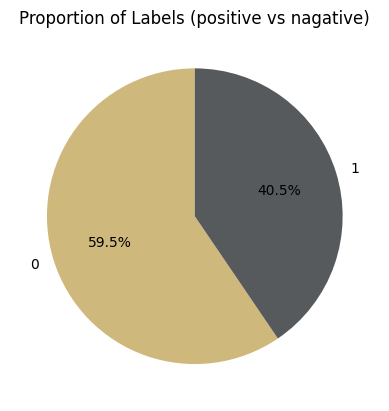

label
0    130908
1     89117
Name: count, dtype: int64


In [3]:
def pieratio(df):
    counts = df.value_counts()
    plt.pie(counts.values, 
            labels=counts.index,   
            autopct='%1.1f%%',     
            startangle=90,         
            colors=["#CFB87C", "#565A5C"])  
    
    plt.title("Proportion of Labels (positive vs nagative)")
    plt.show()
    print(counts)
pieratio(df["label"])

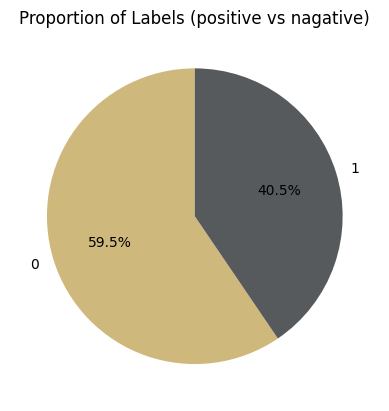

label
0    104726
1     71294
Name: count, dtype: int64


,id,label
68288,63569b2e82cbf30f0f0960b7ff4a5405c0b3a616,0
91672,67561688a8dbb71e87a6c6aece5ddec46d3abaf3,1
11293,da1c8df79026a4a1d5e586d7b38535afa36f9806,1
124538,fd23ba3787641bd15ef6b51a79e26adc9a18f6b0,1
117189,67e900c81f8ed2e2e5deb6431471b43b720c1876,1


In [4]:
train, valid= train_test_split(
    df,
    test_size=0.2,   
    stratify=df["label"],  
    random_state=114514
)
pieratio(train["label"])
train.head()

plot random 4 image in each positive and nagative catigory 
 Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?<br> 
Since all the data are TIFF images, there is no need for data cleaning.<br>
My plan is to build a 3-layer neural network with the following structure:<br>
Conv2D(SeparableConv2D) → MaxPool → Conv2D → MaxPool → Conv2D → GlobalAveragePooling → Dense → Dense.

In the first phase, the goal is to obtain a relatively good model by adding or removing layers and applying data augmentation.<br>
In the second phase, I will focus on tuning hyperparameters.<br>

I am not using any pre-trained models because this is an educational experiment.<br>
Originally, my target score was 90, but since each test took about 1.5 hour on my M2 Pro MacBook, I adjusted my final goal to achieve a score of 88.<br> 

My approach from step 1 to 5 was to use a 3-layer Conv2D model.<br>
During training, it achieved high training accuracy and low training loss, but showed relatively low validation accuracy and high validation loss.<br>
This indicates that the model was slightly overfitting and lacked generalization ability, which would likely lead to a low Kaggle score despite the seemingly good training results.<br>

To address this, I replaced the standard Conv2D layers with SeparableConv2D, since our dataset is not very large and fewer parameters can help the model train more effectively.<br>
I found that my model performed better when I replaced only the first Conv2D(32) layer with SeparableConv2D.<br>

However, when I replaced all three Conv2D layers with SeparableConv2D, the performance became worse than the pure Conv2D model.<br>
The reason is that although SeparableConv2D reduces parameters, replacing all convolution layers makes the network lose too much representational capacity, resulting in underfitting.<br>

Therefore, in my final model, I only replaced the last Conv2D(128) layer with SeparableConv2D.<br>
This way, the model preserves rich feature extraction from the early layers (Conv2D(32) and Conv2D(64)), while still reducing parameters at the deeper layer (36864 → 8768), achieving a good balance between model complexity and generalization.<br>

Under this design, the training process became smoother than in other models, and the validation accuracy was more stable and satisfactory.
As I learned from last week’s assignment, validation accuracy is a critical metric for measuring a model’s generalization ability, so I believe this design is more reliable.<br>

the model in this file is 3-layer neural and each layer include sub-layer

In [5]:
#id_label = {k:v for k,v in zip(df.id.values, df.label.values)}
IMG_SIZE = 96

def loadimage(path, label = None):
    
    def _load(path_str):
        img = Image.open(path_str.numpy().decode("utf-8"))  
        img = img.resize((IMG_SIZE, IMG_SIZE))             
        img = np.array(img).astype(np.float32) / 255.0      
        if img.ndim == 2:                                  
            img = np.stack([img] * 3, axis=-1)
        return img

    img = tf.py_function(func=_load, inp=[path], Tout=tf.float32)
    img.set_shape([IMG_SIZE, IMG_SIZE, 3]) 
    return img, label
    
def loadinferimage(path):
     def _load(path_str):
        img = Image.open(path_str.numpy().decode("utf-8"))  
        img = img.resize((IMG_SIZE, IMG_SIZE))             
        img = np.array(img).astype(np.float32) / 255.0      
        if img.ndim == 2:                                  
            img = np.stack([img] * 3, axis=-1)
        return img
         
     img = tf.py_function(_load, [path], tf.float32)
     img.set_shape([IMG_SIZE, IMG_SIZE, 3])
     return img

def augment(image, label):
    image = tf.image.random_flip_left_right(image)   
    image = tf.image.random_flip_up_down(image)      
    image = tf.image.random_brightness(image, 0.2)   
    image = tf.image.random_contrast(image, 0.8, 1.2)     
    return image, label



In [6]:
def make_dataset(df, img_dir, batch_size=64, shuffle=True):
    
    paths = [os.path.join(img_dir, f"{id}.tif") for id in df['id']]

    labels = df['label'].values
    
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    
    ds = ds.map(lambda x, y: loadimage(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds
def make_infer_dataset(df, img_dir, batch_size=64):
    paths = [os.path.join(img_dir, f"{_id}.tif") for _id in df['id']]
    
    ids   = df['id'].values
    
    ds_img = tf.data.Dataset.from_tensor_slices(paths).map(
        lambda p: loadinferimage(p), num_parallel_calls=tf.data.AUTOTUNE
    )
    
    ds_id  = tf.data.Dataset.from_tensor_slices(ids)
    
    ds = tf.data.Dataset.zip((ds_img, ds_id))  
    
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(train, trainpath, batch_size=64)
valid_ds = make_dataset(valid, trainpath, batch_size=64, shuffle=False)

#train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

#valid_ds = valid_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

In [7]:
l2 = 0.001
IMG_SIZE = 96
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

"""
#model 5
model = models.Sequential([
    layers.Conv2D(32, (3,3),  input_shape=(IMG_SIZE, IMG_SIZE, 3)),#activation='relu',
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(32, (3,3)),#approch 2
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, (3,3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    #layers.Dropout(0.3),
    
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(128, (3,3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D((2,2)),
    
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu')
    layers.Dense(64, activation = 'relu')
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  
#model 6
    model = models.Sequential([
    layers.Conv2D(32, (3,3),  input_shape=(IMG_SIZE, IMG_SIZE, 3)),#activation='relu',
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(32, (3,3)),#approch 2
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, (3,3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    #layers.Dropout(0.3),
    
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(128, (3,3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D((2,2)),
    
    layers.GlobalAveragePooling2D(),
    layers.Dense(128),#, activation='relu'
    layers.Dense(64), #, activation = 'relu'
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  
])
])
   layers.Conv2D(32, 1, strides=1, padding='same', kernel_regularizer=regularizers.l2(l2))(shortcut)
    layers.SeparableConv2D(32,3,strides=1,padding='same',
            depthwise_regularizer=regularizers.l2(l2),
            pointwise_regularizer=regularizers.l2(l2))
    layers.SeparableConv2D(32, 3,padding='same',
            depthwise_regularizer=regularizers.l2(l2),
            pointwise_regularizer=regularizers.l2(l2))
    layers.Add()([shortcut, x])
    
    layers.BatchNormalization()(x)

    model = models.Sequential([
    layers.Conv2D(32, (3,3),  input_shape=(IMG_SIZE, IMG_SIZE, 3), padding='same', 
        kernel_regularizer=tf.keras.regularizers.l2(0.001)),#activation='relu',
    layers.BatchNormalization(),
    layers.Activation("relu"),
    
    #layers.Conv2D(32, (3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),#approch 2
    #layers.BatchNormalization(),
    #layers.Activation('relu'),

    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    #layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    #layers.BatchNormalization(),
    #layers.Activation('relu'),
    
    #layers.Dropout(0.3),
    
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    
    #layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    #layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.MaxPool2D((2,2)),
    
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.001)),#, activation='relu'
    layers.Dense(64,  kernel_regularizer=tf.keras.regularizers.l2(0.001)), #, activation = 'relu'
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  
#model 10
l2 = 0.001
IMG_SIZE = 96

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Block 1
x = layers.Conv2D(32, (3,3), padding='same', 
                  kernel_regularizer=regularizers.l2(l2))(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

shortcut = layers.Conv2D(32, 1, strides=1, padding='same',
                         kernel_regularizer=regularizers.l2(l2))(x)

x = layers.SeparableConv2D(32, 3, padding='same',
                           depthwise_regularizer=regularizers.l2(l2),
                           pointwise_regularizer=regularizers.l2(l2))(x)
x = layers.SeparableConv2D(32, 3, padding='same',
                           depthwise_regularizer=regularizers.l2(l2),
                           pointwise_regularizer=regularizers.l2(l2))(x)

x = layers.Add()([shortcut, x])   
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.MaxPooling2D(2,2)(x)


x = layers.Conv2D(64, (3,3), padding='same', 
                  kernel_regularizer=regularizers.l2(l2))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(2,2)(x)


x = layers.Conv2D(128, (3,3), padding='same', 
                  kernel_regularizer=regularizers.l2(l2))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(2,2)(x)


x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, kernel_regularizer=regularizers.l2(l2))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)

#model 12


inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Block 1
x = layers.Conv2D(32, (3,3), padding='same', 
                  kernel_regularizer=regularizers.l2(l2))(inputs)
x = data_augmentation(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

shortcut1 = layers.Conv2D(32, 1, strides=1, padding='same',
                         kernel_regularizer=regularizers.l2(l2))(x)

x = layers.SeparableConv2D(32, 3, padding='same',
                           depthwise_regularizer=regularizers.l2(l2),
                           pointwise_regularizer=regularizers.l2(l2))(x)
x = layers.SeparableConv2D(32, 3, padding='same',
                           depthwise_regularizer=regularizers.l2(l2),
                           pointwise_regularizer=regularizers.l2(l2))(x)

x = layers.Add()([shortcut1, x])   
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.MaxPooling2D(2,2)(x)
#x = layers.Dropout(0.3)(x)
shortcut2 = layers.Conv2D(64, 1, strides=2, padding='same',
                         kernel_regularizer=regularizers.l2(l2))(x)

x = layers.SeparableConv2D(64, 3, strides=2, padding='same',
                           depthwise_regularizer=regularizers.l2(l2),
                           pointwise_regularizer=regularizers.l2(l2))(x)
x = layers.SeparableConv2D(64, 3, padding='same',
                           depthwise_regularizer=regularizers.l2(l2),
                           pointwise_regularizer=regularizers.l2(l2))(x)

x = layers.Add()([shortcut2, x])   
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.MaxPooling2D(2,2)(x)

x = layers.Conv2D(128, (3,3), padding='same', 
                  kernel_regularizer=regularizers.l2(l2))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(2,2)(x)


x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, kernel_regularizer=regularizers.l2(l2))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
])
"""

"""
#model 17
l2 = 0.001
IMG_SIZE = 96
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
# Block 1
x = layers.Conv2D(32, (3,3), padding='same', 
                  kernel_regularizer=regularizers.l2(l2))(inputs)

x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

shortcut1 = layers.Conv2D(32, 1, strides=1, padding='same' )(x)#,kernel_regularizer=regularizers.l2(l2))(x)

x = layers.SeparableConv2D(32, 3, padding='same')(x)
                           #depthwise_regularizer=regularizers.l2(l2),
                           #pointwise_regularizer=regularizers.l2(l2))(x)
x = layers.SeparableConv2D(32, 3, padding='same')(x)
                           #depthwise_regularizer=regularizers.l2(l2),
                           #pointwise_regularizer=regularizers.l2(l2))(x)

x = layers.Add()([shortcut1, x])   
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.MaxPooling2D(2,2)(x)

shortcut2 = layers.Conv2D(64, 1, strides=2, padding='same')(x)
                         #kernel_regularizer=regularizers.l2(l2))(x)

x = layers.SeparableConv2D(64, 3, strides=2, padding='same')(x)
                           #depthwise_regularizer=regularizers.l2(l2),
                           #pointwise_regularizer=regularizers.l2(l2))(x)
x = layers.SeparableConv2D(64, 3, padding='same')(x)
                           #depthwise_regularizer=regularizers.l2(l2),
                           #pointwise_regularizer=regularizers.l2(l2))(x)

x = layers.Add()([shortcut2, x])   
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.MaxPooling2D(2,2)(x)
#layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(l2))(x)

shortcut3 = layers.Conv2D(128, 1, strides=2, padding='same')(x)
                         #kernel_regularizer=regularizers.l2(l2))(x)
x = layers.SeparableConv2D(128, 3, strides=2, padding='same')(x)
                           #depthwise_regularizer=regularizers.l2(l2),
                           #pointwise_regularizer=regularizers.l2(l2))(x)
x = layers.SeparableConv2D(128, 3, padding='same')(x)
                           #depthwise_regularizer=regularizers.l2(l2),
                           #pointwise_regularizer=regularizers.l2(l2))(x)
x = layers.Add()([shortcut3, x])  
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(2,2)(x)


x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, kernel_regularizer=regularizers.l2(l2))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)
"""
"""
early_stop = EarlyStopping(
    monitor='val_accuracy',  
    patience=2,               
    restore_best_weights=True 
)
"""
"""
#model18
inputs = tf.keras.Input(shape=(96, 96, 3))
x = data_augmentation(inputs)
#x = input

# Block 1
x = layers.Conv2D(32, (3,3), padding='same', 
                  kernel_regularizer=regularizers.l2(l2))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

shortcut = layers.Conv2D(32, 1, strides=1, padding='same',
                         kernel_regularizer=regularizers.l2(l2))(x)
shortcut = layers.BatchNormalization()(shortcut)
shortcut = layers.Activation("relu")(shortcut)
x = layers.Add()([shortcut, x])   
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.MaxPooling2D(2,2)(x)


x = layers.Conv2D(64, (3,3), padding='same', 
                  kernel_regularizer=regularizers.l2(l2))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
"""
"""
x = layers.SeparableConv2D(64, 3, padding='same',
                           depthwise_regularizer=regularizers.l2(l2),
                           pointwise_regularizer=regularizers.l2(l2))(x) #
x = layers.BatchNormalization()(x)#
x = layers.Activation("relu")(x)
"""
"""
x = layers.MaxPooling2D(2,2)(x)

x = layers.Conv2D(128, (3,3), padding='same', 
                  kernel_regularizer=regularizers.l2(l2))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(2,2)(x)
"""
"""
x = layers.SeparableConv2D(128, 3, padding='same',
                           depthwise_regularizer=regularizers.l2(l2),
                           pointwise_regularizer=regularizers.l2(l2))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
"""
"""
x = layers.MaxPooling2D(2,2)(x)

#x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, kernel_regularizer=regularizers.l2(l2))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)
"""

# Input layer
inputs = tf.keras.Input(shape=(96, 96, 3))
x = data_augmentation(inputs)
# Initial Conv block
x = layers.Conv2D(32, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
    # Residual branch
shortcut = layers.Conv2D(32, 3, padding='same')(x)

    # Separable conv branch
x1 = layers.SeparableConv2D(32, 3, padding='same')(x)
x1 = layers.SeparableConv2D(32, 3, padding='same')(x1)

    # Add residual + separable conv
x = layers.Add()([shortcut, x1])
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x) 

x = layers.MaxPooling2D(pool_size=(2, 2))(x)


x = layers.Conv2D(64, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(128, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# Global pooling and dense layers
#x = layers.Flatten()(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

# Build model
model = models.Model(inputs=inputs, outputs=output)



early_stop = EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True, verbose=1
)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=2, verbose=1)
#class_weight = {0: 1.0, 1: 1.1}
checkpoint = ModelCheckpoint(
    "best_model.h5",              
    monitor="val_accuracy",       
    save_best_only=True,        
    mode="max",
    verbose=1 
    #class_weight=class_weight
)
def focal_loss(gamma=2., alpha=.25):
    def loss(y_true, y_pred):
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        return -tf.reduce_mean(alpha * tf.pow(1. - pt, gamma) * tf.math.log(tf.clip_by_value(pt, 1e-8, 1.)))
    return loss

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, clipnorm=1.0),
              loss='binary_crossentropy',#,focal_loss()
              metrics=['accuracy'])#, tf.keras.metrics.AUC(name='auc')

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 96, 96, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 96, 96, 32)           896       ['sequential[0][0]']          
                                                                                                  
 batch_normalization (Batch  (None, 96, 96, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                               

In [ ]:

history0 = model.fit(
    train_ds,   
    validation_data=valid_ds,
    epochs=20,
    callbacks=[lr_scheduler, early_stop, checkpoint]# 
)
print("finished")

Epoch 1/20
2751/2751 [==============================] - ETA: 0s - loss: 0.7100 - accuracy: 0.8262
Epoch 1: val_accuracy improved from -inf to 0.72146, saving model to best_model.h5
2751/2751 [==============================] - 415s 100ms/step - loss: 0.7100 - accuracy: 0.8262 - val_loss: 0.7714 - val_accuracy: 0.7215 - lr: 1.0000e-04
Epoch 2/20


/opt/homebrew/anaconda3/envs/tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2751/2751 [==============================] - ETA: 0s - loss: 0.5254 - accuracy: 0.8612
Epoch 2: val_accuracy improved from 0.72146 to 0.77173, saving model to best_model.h5
2751/2751 [==============================] - 429s 103ms/step - loss: 0.5254 - accuracy: 0.8612 - val_loss: 0.6725 - val_accuracy: 0.7717 - lr: 1.0000e-04
Epoch 3/20
2751/2751 [==============================] - ETA: 0s - loss: 0.4427 - accuracy: 0.8758
Epoch 3: val_accuracy improved from 0.77173 to 0.77821, saving model to best_model.h5
2751/2751 [==============================] - 426s 101ms/step - loss: 0.4427 - accuracy: 0.8758 - val_loss: 0.6773 - val_accuracy: 0.7782 - lr: 1.0000e-04
Epoch 4/20


In [9]:
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, clipnorm=1.0),
              loss='binary_crossentropy',#,focal_loss()
              metrics=['accuracy'])#, tf.keras.metrics.AUC(name='auc')
history1 = model.fit(
    train_ds,   
    validation_data=valid_ds,
    epochs=20,
    callbacks=[lr_scheduler, early_stop, checkpoint]# 
)
print("finished")

Epoch 1/20
2751/2751 [==============================] - ETA: 0s - loss: 0.3555 - accuracy: 0.8492
Epoch 1: val_accuracy improved from -inf to 0.67424, saving model to best_model.h5
2751/2751 [==============================] - 451s 110ms/step - loss: 0.3555 - accuracy: 0.8492 - val_loss: 1.0301 - val_accuracy: 0.6742 - lr: 0.0010
Epoch 2/20


/opt/homebrew/anaconda3/envs/tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2751/2751 [==============================] - ETA: 0s - loss: 0.2911 - accuracy: 0.8801
Epoch 2: val_accuracy improved from 0.67424 to 0.81675, saving model to best_model.h5
2751/2751 [==============================] - 3677s 1s/step - loss: 0.2911 - accuracy: 0.8801 - val_loss: 0.3967 - val_accuracy: 0.8167 - lr: 0.0010
Epoch 3/20
2751/2751 [==============================] - ETA: 0s - loss: 0.2597 - accuracy: 0.8958
Epoch 3: val_accuracy did not improve from 0.81675
2751/2751 [==============================] - 452s 111ms/step - loss: 0.2597 - accuracy: 0.8958 - val_loss: 0.8234 - val_accuracy: 0.7390 - lr: 0.0010
Epoch 4/20
2751/2751 [==============================] - ETA: 0s - loss: 0.2390 - accuracy: 0.9060
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 4: val_accuracy did not improve from 0.81675
2751/2751 [==============================] - 449s 112ms/step - loss: 0.2390 - accuracy: 0.9060 - val_loss: 2.1904 - val_accuracy: 0.6986 - lr: 0.0010
Epoc

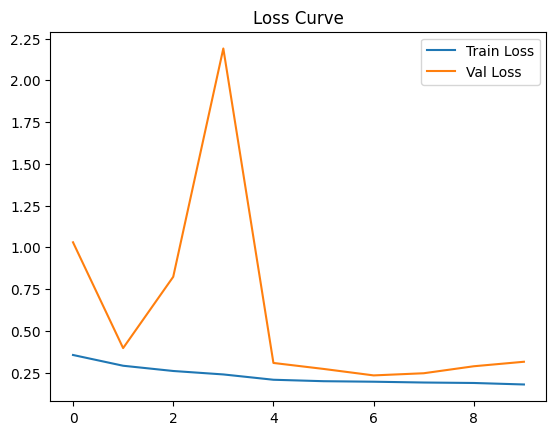

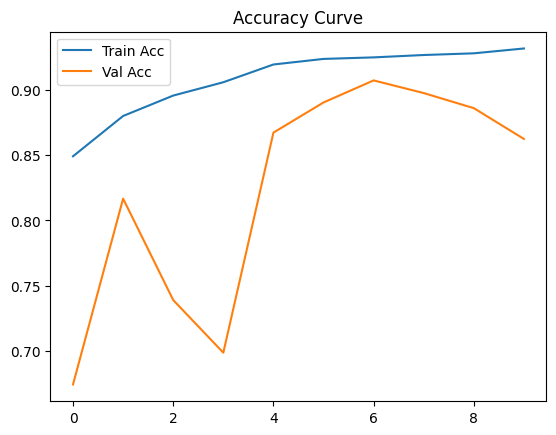

688/688 [==============================] - 46s 66ms/step


In [10]:
history = history1
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()


plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend()
plt.title("Accuracy Curve")
plt.show()



y_pred = model.predict(valid_ds)
  

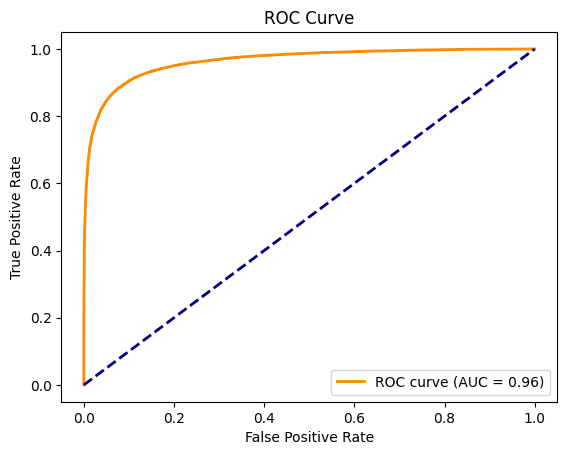

Best threshold: 0.47817102
Accuracy: 0.907283263265538
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     26182
           1       0.89      0.88      0.89     17823

    accuracy                           0.91     44005
   macro avg       0.90      0.90      0.90     44005
weighted avg       0.91      0.91      0.91     44005

688/688 [==============================] - 45s 66ms/step - loss: 0.2332 - accuracy: 0.9074
Validation Loss: 0.2332238107919693, Validation Accuracy: 0.9074196219444275


In [11]:
y_true = np.concatenate([y for x, y in valid_ds], axis=0)


fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)


plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()
#fpr, tpr, thresholds = roc_curve(y_true, y_pred)
j_scores = tpr - fpr   
best_threshold = thresholds[j_scores.argmax()]
print("Best threshold:", best_threshold)
y_pred_classes = (y_pred > best_threshold).astype("int32")

print("Accuracy:", accuracy_score(y_true, y_pred_classes))
print(classification_report(y_true, y_pred_classes))
loss, acc = model.evaluate(valid_ds)
print(f"Validation Loss: {loss}, Validation Accuracy: {acc}")

In [ ]:
# read file from test folder, load image to data frame, load solution file as a y_true, compare accuracy and generate y_pred to submission file

In [12]:
samplepath = f"{path}sample_submission.csv"

testdf = pd.read_csv(samplepath)
print(testdf.shape)
test_ds = make_infer_dataset(testdf, testpath, batch_size=64)


probs = model.predict(test_ds.map(lambda x, *_: x), verbose=0).squeeze()
print("probs stats -> min:", probs.min(), "max:", probs.max(), "mean:", probs.mean())
print("first 20 probs:", probs[:20])


predtest = (probs >= 0.5).astype(int)
print("preds unique:", np.unique(predtest, return_counts=True))


(57458, 2)
probs stats -> min: 2.3758944e-06 max: 1.0 mean: 0.37454656
first 20 probs: [0.03317556 0.06170096 0.0095264  0.06035478 0.05847759 0.9066892
 0.46073198 0.95016986 0.03322257 0.0394448  0.7407353  0.0496599
 0.00747492 0.00434955 0.02017925 0.9891588  0.00943259 0.07622702
 0.04906188 0.98659503]
preds unique: (array([0, 1]), array([36933, 20525]))


In [13]:
y_pred_test = (predtest > 0.5).astype("int32")#best_threshold

#print("Accuracy:", accuracy_score(y_truetest, y_pred_test))
#print(classification_report(y_truetest, y_pred_test))
#loss, acc = model.evaluate(test_ds)
#print(f"Validation Loss: {loss}, Validation Accuracy: {acc}")

In [69]:
import collections
np.bincount(y_truetest)
print(collections.Counter(y_truetest))
countpred = y_pred_test.copy().reshape(1, -1)
print(collections.Counter(countpred[0]))
#xtest = [y for x, y in test_ds]
print(test_ds)


Counter({0: 57458})
Counter({0: 38985, 1: 18473})
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>
(64, 96, 96, 3) <dtype: 'float32'> 0.0 1.0


In [71]:
for xb, yb in train_ds.take(1):
    print("train:", xb.shape, xb.dtype, float(tf.reduce_min(xb)), float(tf.reduce_max(xb)))
    break

for xb, yb in valid_ds.take(1):
    print("val:", xb.shape, xb.dtype, float(tf.reduce_min(xb)), float(tf.reduce_max(xb)))
    break

for xb, ids in test_ds.take(1):   # infer_ds returns (image, id)
    print("test:", xb.shape, xb.dtype, float(tf.reduce_min(xb)), float(tf.reduce_max(xb)))
    break

2025-09-09 11:49:27.407035: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:97: Filling up shuffle buffer (this may take a while): 12470 of 176020
2025-09-09 11:49:47.406188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:97: Filling up shuffle buffer (this may take a while): 37566 of 176020
2025-09-09 11:50:07.407219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:97: Filling up shuffle buffer (this may take a while): 62420 of 176020
2025-09-09 11:50:27.405334: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:97: Filling up shuffle buffer (this may take a while): 88012 of 176020
2025-09-09 11:50:37.406023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:97: Filling up shuffle buffer (this may take a while): 100525 of 176020
2025-09-09 11:50:57.405170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:97: Filling up shuffle buf

train: (64, 96, 96, 3) <dtype: 'float32'> 0.0 1.0
val: (64, 96, 96, 3) <dtype: 'float32'> 0.0 1.0
test: (64, 96, 96, 3) <dtype: 'float32'> 0.0 1.0


same model and same file, should change the file name every time.

In [ ]:
#######

In [14]:
testdf['label'] = y_pred_test
testdf.to_csv(f"{path}23.csv", index=False)
model.save("cnn approach 23.h5") 

/opt/homebrew/anaconda3/envs/tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
